## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc

EnvironmentNameNotFound: Could not find conda environment: pitn
You can list all discoverable environments with `conda info --envs`.




True

In [3]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash

In [4]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2023-05-10T15:06:13.071608-04:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: 99144ba3d8857936fc1a53ea14d81afb45965459

nibabel   : 3.2.2
numpy     : 1.23.4
pitn      : 0.0.post1.dev258+g67cc03c.d20230208
einops    : 0.6.0
sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
skimage   : 0.19.3
matplotlib: 3.5.2
pandas    : 1.5.2
seaborn   : 0.12.1




## Data Loading

In [56]:
subj_dir = Path("/data/srv/outputs/pitn/vcu/preproc")
assert subj_dir.exists()

subj_list = (
    "P_03",
    "P_33",
)

In [57]:
subj_data = Box(default_box=True)

for subj_id in subj_list:
    subj_dict = Box(default_box=True)
    d = subj_dir / subj_id
    assert d.exists()

    d_diff = subj_dict.files.diffusion
    d_diff.dwi = d / "diffusion" / f"{subj_id}_dwi.nii.gz"
    d_diff.lesion_mask = d / "diffusion" / "ms_lesion_mask.nii.gz"
    d_diff.mask = d / "diffusion" / "dwi_mask.nii.gz"
    d_diff.wm_mask = (
        d
        / "diffusion"
        / "freesurfer_segmentations_reg-dwi"
        / "mrtrix_5tt/roi_masks"
        / "white_matter.nii.gz"
    )

    param_maps = d_diff.param_maps
    for p in (d / "diffusion" / "parameter_maps").glob("*"):
        p_group_name = p.name
        print(p_group_name)
        for im in p.glob("*.nii.gz"):
            im_name = im.name.replace("".join(im.suffixes), "")
            im_name = im_name.replace(subj_id, "")
            if "model_fit" in im_name:
                continue
            param_maps[p_group_name][im_name] = im

    d_diff.param_maps = param_maps

    subj_dict.files.diffusion = d_diff

    subj_data[subj_id] = subj_dict

msdki
dki
dti
noddi


In [24]:
subj_data["P_33"].files.diffusion.keys()

dict_keys(['dwi', 'lesion_mask', 'mask', 'wm_mask', 'param_maps'])

In [58]:
data_table = {
    "subj_id": list(),
    "group": list(),
    "metric_name": list(),
    "lesion_values": list(),
    "lesion_std": list(),
    "nawm_values": list(),
    "nawm_std": list(),
}
for subj_id in subj_list:
    d = subj_data[subj_id]
    lesion_mask = nib.load(d.files.diffusion.lesion_mask).get_fdata().astype(bool)
    wm_mask = nib.load(d.files.diffusion.wm_mask).get_fdata().astype(bool)
    wm_mask = wm_mask * (~lesion_mask)

    for g, p in d.files.diffusion.param_maps.items():
        for p_name, p_f in p.items():

            p_im = nib.load(p_f).get_fdata().astype(np.float32)
            if len(p_im.shape) == 4:
                continue
            data_table["subj_id"].append(subj_id)
            data_table["group"].append(g)
            data_table["metric_name"].append(p_name)
            wm_vals = p_im[wm_mask].mean()
            lesion_vals = p_im[lesion_mask].mean()
            data_table["lesion_values"].append(lesion_vals)
            data_table["nawm_values"].append(wm_vals)
            data_table["lesion_std"].append(p_im[lesion_mask].std())
            data_table["nawm_std"].append(p_im[wm_mask].std())

In [55]:
pd.DataFrame.from_dict(subj_table)

,group,metric_name,lesion_values,lesion_std,nawm_values,nawm_std
0,msdki,P_03_mean_signal_diffusivity,0.001661,0.000449,9.003874e-04,2.489230e-04
1,msdki,P_03_mean_signal_kurtosis,0.621448,0.135991,1.692546e+06,4.339655e+08
2,msdki,P_03_s0_non-diffusion-signal,10031.946289,3536.721436,4.335026e+03,1.470999e+03
3,dki,P_03_md,0.001696,0.000449,9.250523e-04,2.965114e-04
4,dki,P_03_mean_kurtosis_tensor,0.607074,0.127077,8.715969e-01,2.313210e-01
5,dki,P_03_rd,0.001466,0.000469,7.568386e-04,2.521345e-04
6,dki,P_03_mean_kurtosis,0.608114,0.129773,8.825707e-01,2.122722e-01
7,dki,P_03_radial_kurtosis,0.676148,0.181646,1.033229e+00,3.527519e-01
8,dki,P_03_ad,0.002156,0.000486,1.261480e-03,5.941894e-04
9,dki,P_03_fa,0.262496,0.115660,3.190169e-01,1.624224e-01


In [59]:
pd.DataFrame.from_dict(subj_table)

,group,metric_name,lesion_values,lesion_std,nawm_values,nawm_std
0,msdki,P_33_mean_signal_kurtosis,0.884754,0.269529,1.378750e+06,3.416266e+08
1,msdki,P_33_s0_non-diffusion-signal,8180.331055,5871.430664,5.644811e+03,2.830113e+03
2,msdki,P_33_mean_signal_diffusivity,0.001261,0.000750,9.411682e-04,4.007596e-04
3,dki,P_33_mean_kurtosis_tensor,0.836755,0.241145,8.648840e-01,2.317971e-01
4,dki,P_33_axial_kurtosis,0.675113,0.183736,7.438417e-01,1.566961e-01
5,dki,P_33_mean_kurtosis,0.865643,0.265309,8.825606e-01,2.576886e-01
6,dki,P_33_md,0.001300,0.000751,9.595744e-04,4.046239e-04
7,dki,P_33_ad,0.001809,0.000774,1.263852e-03,4.587015e-04
8,dki,P_33_radial_kurtosis,1.159119,0.558492,1.085289e+00,5.034515e-01
9,dki,P_33_fa,0.396646,0.197168,3.059337e-01,1.988541e-01


/home/tas6hh/miniconda/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


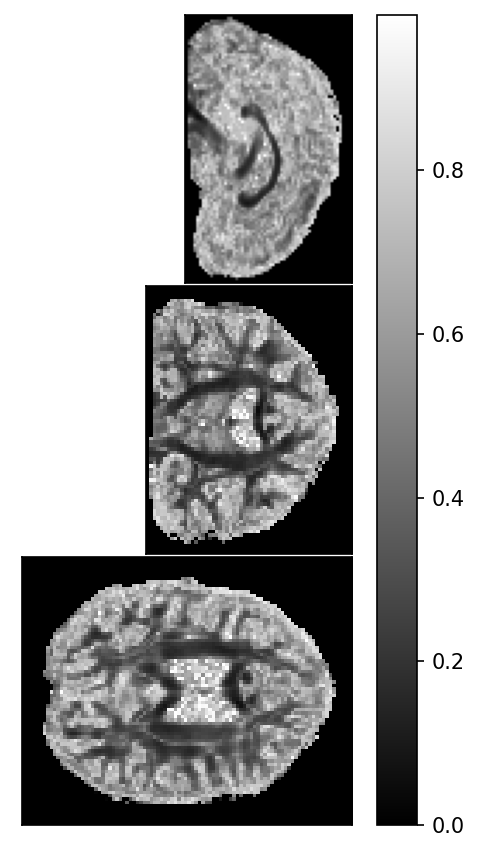

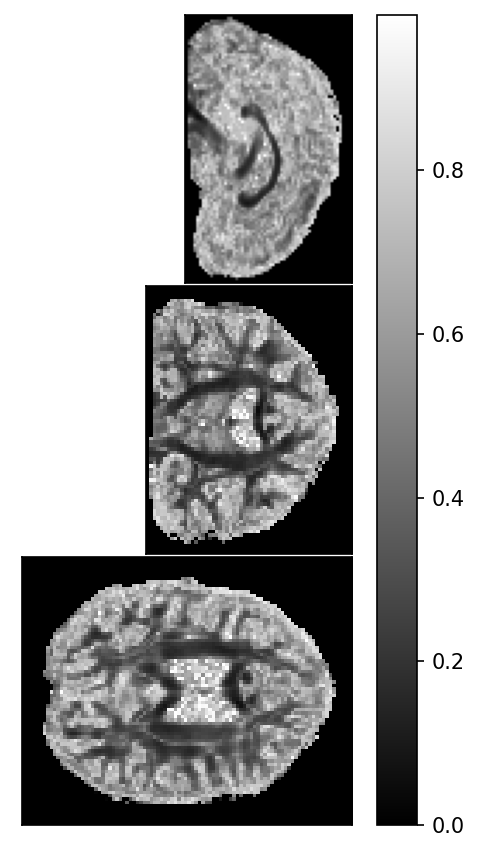

In [54]:
fig = plt.figure(dpi=150)
pitn.viz.plot_vol_slices(
    nib.load(
        subj_dict.files.diffusion.param_maps.noddi[
            "SD1WatsonDistributed_1_SD1Watson_1_odi"
        ]
    ).get_fdata(),
    colorbars="global",
    fig=fig,
)

/home/tas6hh/miniconda/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


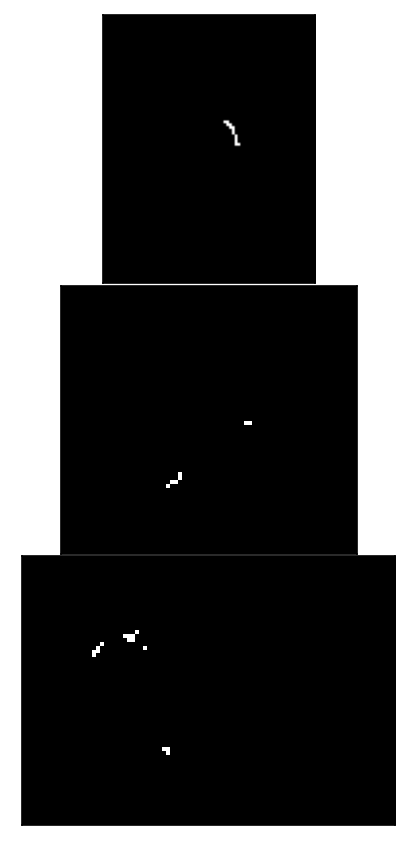

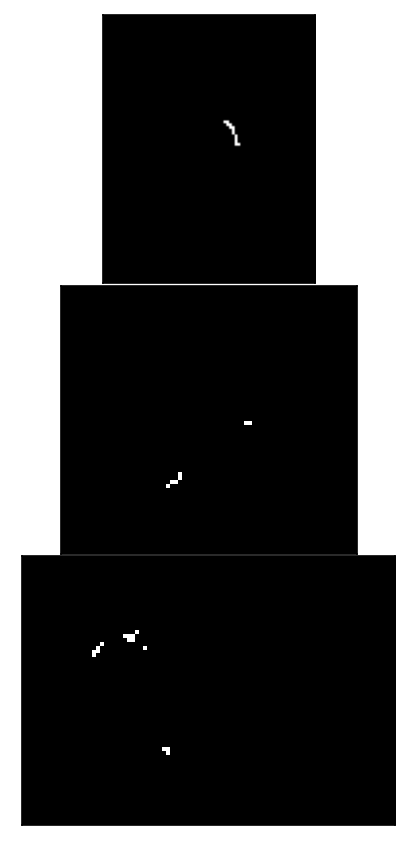

In [49]:
fig = plt.figure(dpi=150)
pitn.viz.plot_vol_slices(lesion_mask)